In [1]:
import torch
import clip
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.text import Text
from PIL import Image
import random

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [3]:
model, preprocess = clip.load("ViT-B/32", device=device)

In [4]:
def classify(im, labels):
    image = preprocess(im).unsqueeze(0).to(device)
    text = clip.tokenize(labels).to(device)

    with torch.no_grad():
        image_features = model.encode_image(image)
        text_features = model.encode_text(text)

        logits_per_image, logits_per_text = model(image, text)
        probs = logits_per_image.softmax(dim=-1).cpu().numpy()

    probs = sorted(enumerate(probs[0]), key=lambda x: x[1], reverse=True)
    indices, values = zip(*probs)

    results = {}
    for i in range(len(indices)):
        results[labels[indices[i]]] = values[i]*100
    return results

In [5]:
IMAGE_DIR = "TRAK_scores_100"
NUM_IMAGES = 10
NUM_SAMPLES = 200

indices = range(NUM_SAMPLES)

In [6]:
image_files = sorted(os.listdir(IMAGE_DIR))
image_files = [file for file in image_files if file.endswith('.jpg')]

target_files = []
image_info = {}

if os.path.exists('image_info.npy'):
    image_info = np.load('image_info.npy',allow_pickle='TRUE').item()

for image_file in image_files:

    if image_file.split(".")[-1] != "jpg":
        continue

    i = int(image_file.split("_")[0])
    class_id = int(image_file.split("_")[1])
    is_target = image_file.split("_")[2] == "target"
    score = None

    if not is_target:
        score = float(image_file.split("_")[2])
    else:
        target_files.append(image_file)

    if image_file not in image_info:
        image_info[image_file] = {
            "i": i,
            "class_id": class_id,
            "is_target": is_target,
            "score": score,
            "label": {}
        }

In [7]:
labels = {
    "location": [
        "city",
        "sky",
        "water",
        "woods",
        "farm",
        "streets",
        "fields",
        "indoor",
        "urban",
    ],
    "color": [
        "red",
        "green",
        "blue",
        "yellow",
        "black",
        "white",
        "brown",
    ],
    "time": [
        "morning",
        "noon",
        "afternoon",
        "evening",
        "night"
    ],
    "size": [
        "very small",
        "small",
        "medium",
        "large",
        "very large"
    ]
}

In [8]:
NUM_TOP_RESULTS = 3


def getLabels(image_file):
    im = Image.open(f"./{IMAGE_DIR}/{image_file}")
    for category in labels.keys():
        if category not in image_info[image_file]["label"]:
            print(f"Classifying {image_file} for {category}")
            image_info[image_file]["label"][category] = classify(im, labels[category])


def getLabelText(image_file):
    text = ""
    for category in labels.keys():
        text += f"{category}:"
        top_labels = sorted(
            image_info[image_file]["label"][category].items(),
            key=lambda x: x[1],
            reverse=True,
        )[:NUM_TOP_RESULTS]
        for label, value in top_labels:
            text += f"\n{label}: {value:.2f}%"
        text += "\n\n"
    text_obj = Text(
        x=15, y=35, text=text, ha="center", va="top", wrap=True, fontsize=10
    )
    text_obj._get_wrap_line_width = lambda: 180
    return text_obj

In [9]:
for image_file in image_files:
    getLabels(image_file)

Classifying 100_2_-0.12_.jpg for location
Classifying 100_2_-0.12_.jpg for color
Classifying 100_2_-0.12_.jpg for time
Classifying 100_2_-0.12_.jpg for size
Classifying 100_2_-0.13_.jpg for location
Classifying 100_2_-0.13_.jpg for color
Classifying 100_2_-0.13_.jpg for time
Classifying 100_2_-0.13_.jpg for size
Classifying 100_2_0.25_.jpg for location
Classifying 100_2_0.25_.jpg for color
Classifying 100_2_0.25_.jpg for time
Classifying 100_2_0.25_.jpg for size
Classifying 100_2_0.27_.jpg for location
Classifying 100_2_0.27_.jpg for color
Classifying 100_2_0.27_.jpg for time
Classifying 100_2_0.27_.jpg for size
Classifying 100_2_0.28_.jpg for location
Classifying 100_2_0.28_.jpg for color
Classifying 100_2_0.28_.jpg for time
Classifying 100_2_0.28_.jpg for size
Classifying 100_2_0.33_.jpg for location
Classifying 100_2_0.33_.jpg for color
Classifying 100_2_0.33_.jpg for time
Classifying 100_2_0.33_.jpg for size
Classifying 100_2_0.35_.jpg for location
Classifying 100_2_0.35_.jpg for c

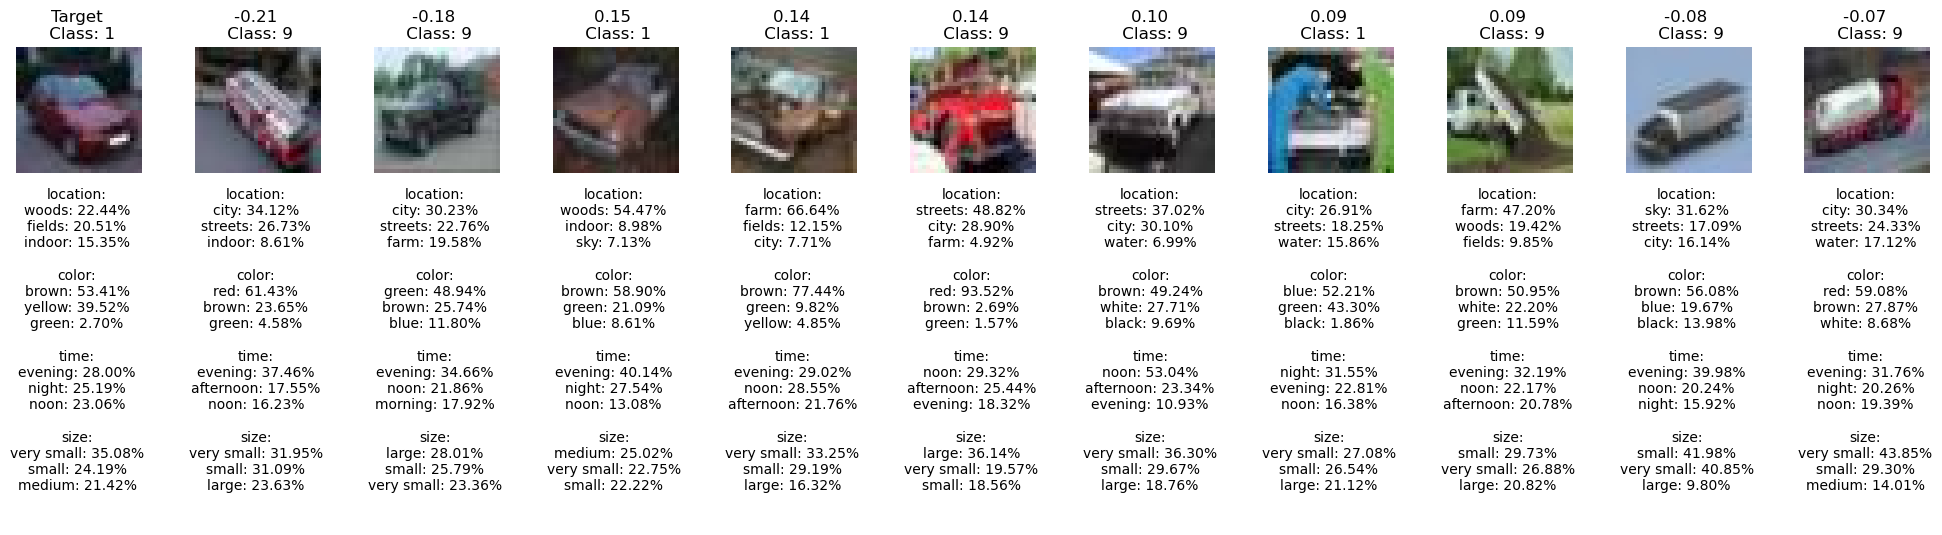

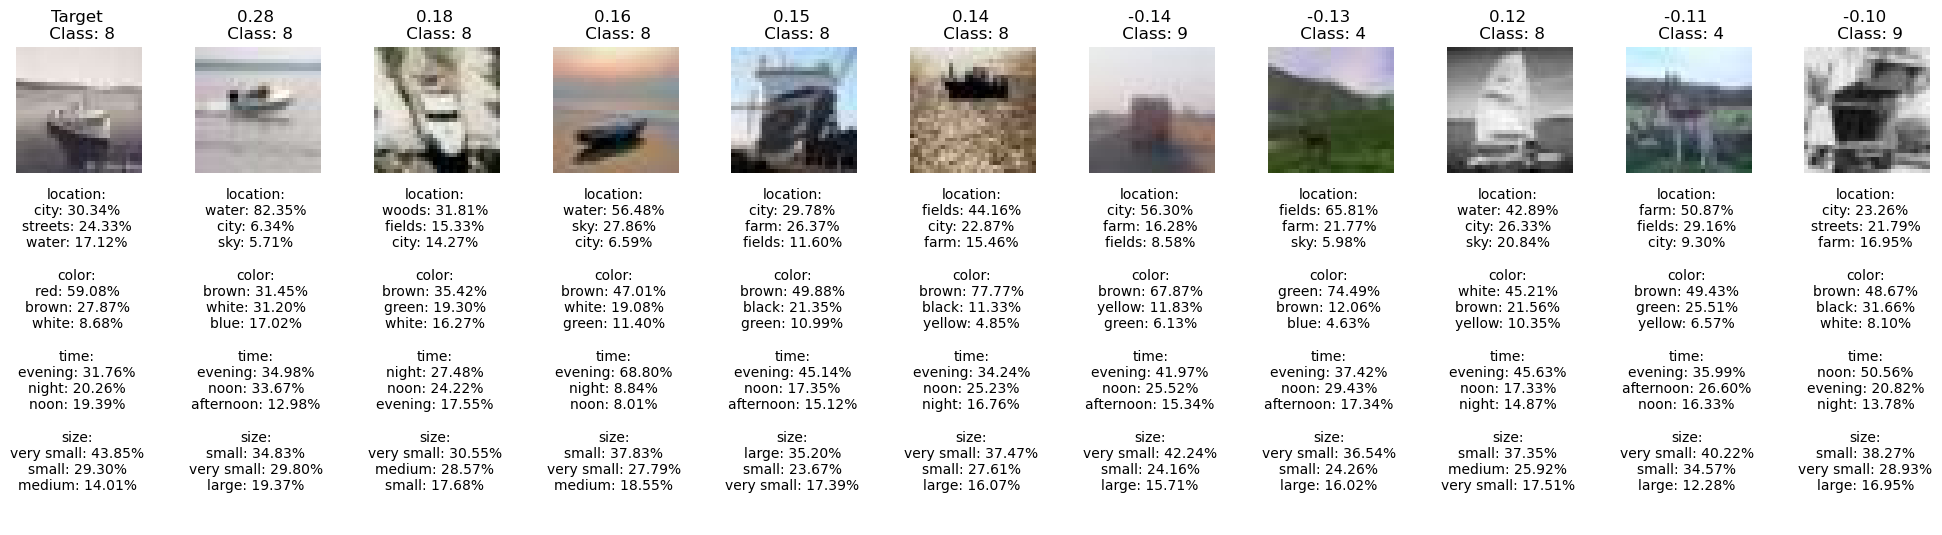

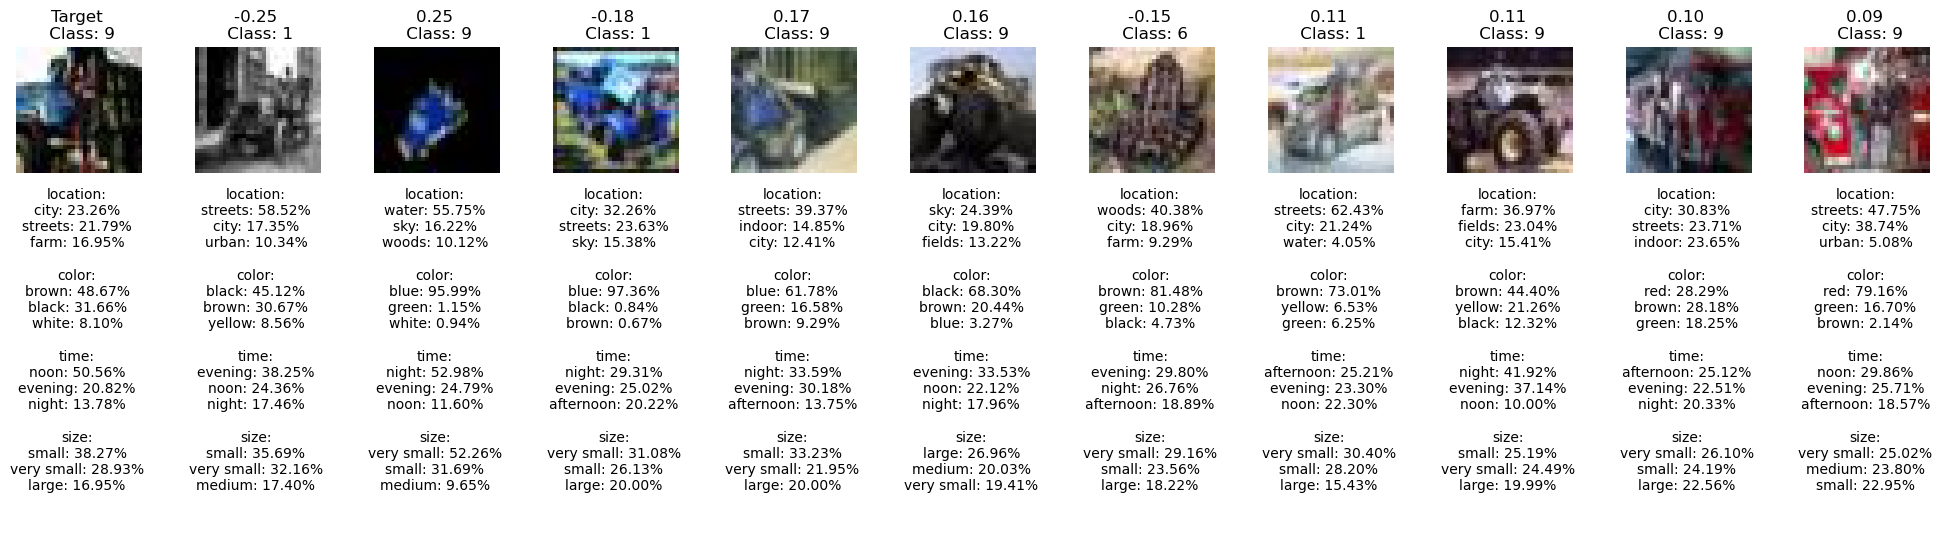

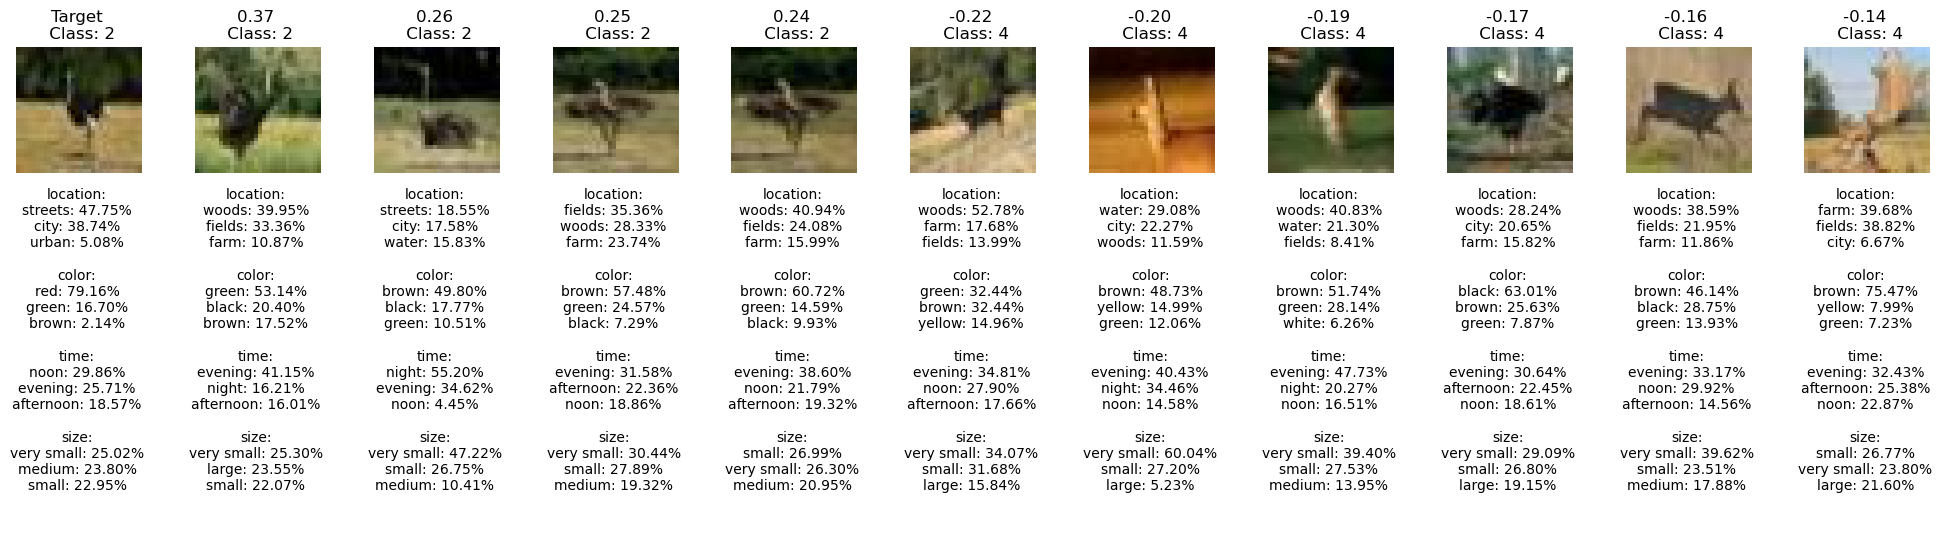

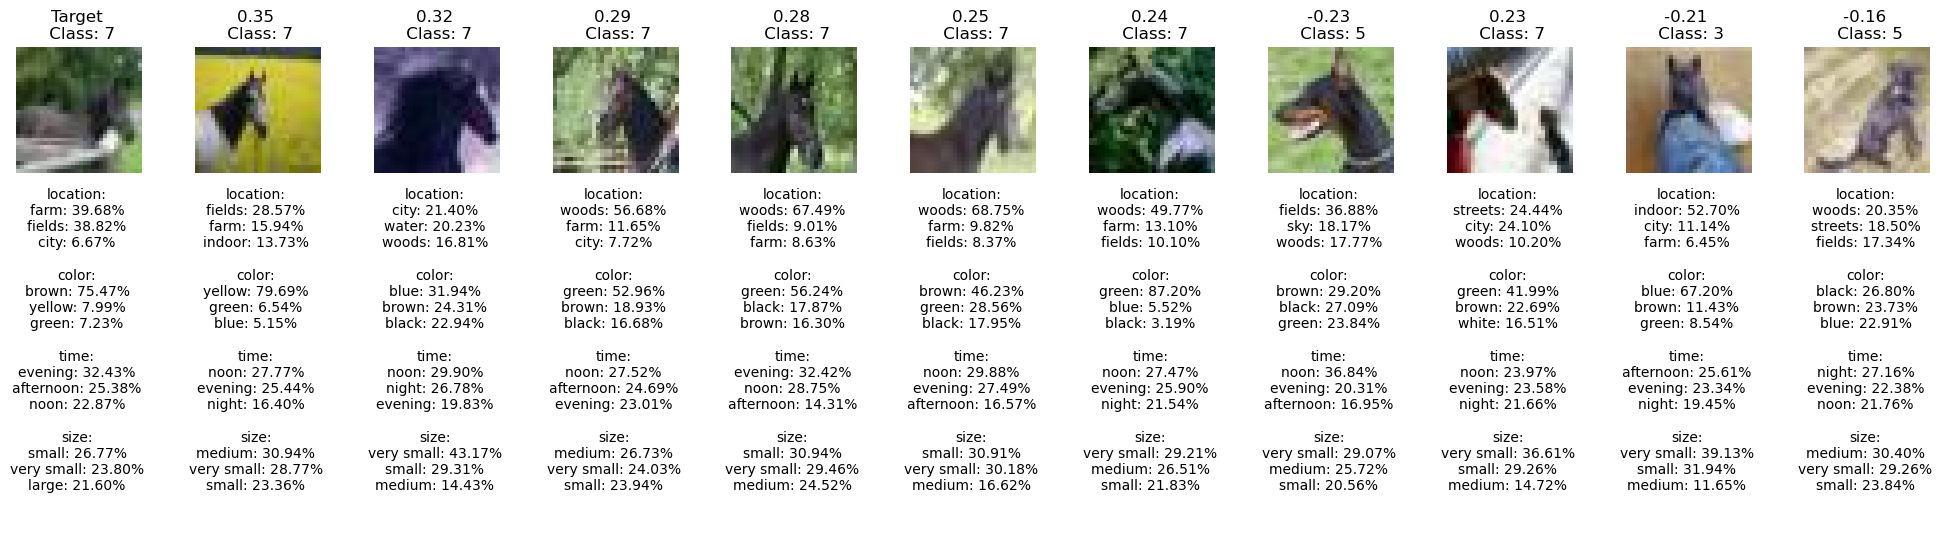

In [10]:
for target_file in random.sample(target_files, 5):
    image_files = [
        image_file
        for image_file in image_info
        if (
            image_info[image_file]["i"] == image_info[target_file]["i"]
            and not image_info[image_file]["is_target"]
        )
    ][::-1][:NUM_IMAGES]

    # Sort image_files by absolute value of score
    image_files = sorted(image_files, key=lambda x: abs(image_info[x]["score"]))[::-1]

    fig, axs = plt.subplots(ncols=(NUM_IMAGES + 1), figsize=(NUM_IMAGES * 2.5, 2))
    plt.subplots_adjust(bottom=0.25)
    axs[0].imshow(Image.open(f"./{IMAGE_DIR}/{target_file}"))
    axs[0].axis("off")
    axs[0].set_title(f"Target \n Class: {image_info[target_file]['class_id']}")

    im = Image.open(f"./{IMAGE_DIR}/{image_file}")
    axs[0]._add_text(getLabelText(image_file))

    for i, image_file in enumerate(image_files):
        if image_info[image_file]["is_target"]:
            continue

        im = Image.open(f"./{IMAGE_DIR}/{image_file}")
        
        axs[i + 1].set_title(
            f"{image_info[image_file]['score']:.2f} \n Class: {image_info[image_file]['class_id']}"
        )
        axs[i + 1].imshow(im)
        axs[i + 1].axis("off")
        axs[i + 1]._add_text(getLabelText(image_file))

In [11]:
np.save('image_info.npy', image_info)